# 1. Data Determined

In [87]:
# data manipulation
import pandas as pd
import datetime
pd.set_option("display.max_columns", 1000)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import gaussian_kde

# experimental design checks
from statsmodels.stats.outliers_influence import variance_inflation_factor
from causalinference import CausalModel

# GLM
import statsmodels.api as sm

# interaction exploration
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# uncertainty driven assessment
import pymc3 as pm

# auxiliary -- actually, a computational shortcut for creating a computational shortcut ;p
from collections import Counter

In [2]:
x = pd.read_csv('experiment.csv', parse_dates=['account_created_at','tier1_converted_at'])
x.dtypes

account_id                           object
treatment_group                      object
supporter                            object
sizing                               object
employees_in_account_plan             int64
marketing_source                     object
discount_code                        object
discount_percentage                   int64
account_created_at           datetime64[ns]
tier1_converted_at           datetime64[ns]
dtype: object

In [3]:
# account_id are unique
x.shape, x.account_id.unique().shape

((55380, 10), (55380,))

In [4]:
# no missing accout initializations
print('missing dates: ',x.account_created_at.isnull().sum())
print('oldest account age: ',(datetime.datetime(2014,12,10)-x.account_created_at).max())
print('newest account age: ',(datetime.datetime(2014,12,10)-x.account_created_at).min())
print('account_created_at > tier1_converted_at: ', (x.account_created_at>x.tier1_converted_at).sum())

missing dates:  0
oldest account age:  603 days 16:42:53.888000
newest account age:  12 days 02:55:11.462000
account_created_at > tier1_converted_at:  0


In [5]:
# 1 missing employ entry
(x.employees_in_account_plan<1).sum()

1

In [6]:
# corrected
x1 = x[~(x.employees_in_account_plan<1)]
x1.shape

(55379, 10)

In [7]:
# no missing treatments -- handful more samples than expected
print('missing treatment: ', x1.treatment_group.isnull().sum())

x1.treatment_group.value_counts()

missing treatment:  0


Control      28682
Treatment    26697
Name: treatment_group, dtype: int64

In [8]:
# supporter is ordinal -- just a handful of missing values
print('missing supporter: ', x1.supporter.isnull().sum())

x1.supporter.value_counts()


missing supporter:  96


weak      33414
medium    21578
strong      291
Name: supporter, dtype: int64

In [9]:
# sizing is ordinal
print('missing sizing: ', x1.sizing.isnull().sum())

x1.sizing.value_counts()


missing sizing:  0


size-01    25091
size-08    17526
size-06     7120
size-05     5045
size-07      592
size-04        3
size-03        1
size-02        1
Name: sizing, dtype: int64

In [10]:
# size-02 through size-04 to be dropped
x2 = x1[x1.sizing.apply(lambda x: x not in ['size-04','size-02','size-03'])]
x2.shape

(55374, 10)

In [11]:
# employees_in_account_plan is small integer
# EXPECTING TO MAKE 5+ CATEGORY MAX
print('missing employees_in_account_plan: ', x2.employees_in_account_plan.isnull().sum())
x2.employees_in_account_plan.value_counts()

missing employees_in_account_plan:  0


1     35023
2     15287
3      3525
4       997
5       295
6       124
7        59
8        24
9        16
10       10
12        5
11        4
13        3
15        1
14        1
Name: employees_in_account_plan, dtype: int64

In [12]:
# marketing_source is categorical -- missing values are VERY frequent
# EXPECTING TO ORDINALIZE BY SIZE
print('missing marketing_source: ', x2.marketing_source.isnull().sum())
x2.marketing_source.value_counts()

missing marketing_source:  24577


source-04    18382
source-05     4841
source-03     2831
source-06     1839
source-01     1730
source-02     1174
Name: marketing_source, dtype: int64

In [13]:
# discount_code is many level categorical -- missing values are EXTREMELY frequent
# UNCLEAR WHAT TO DO HERE... ORDINALIZE BY SIZE?  BINARIZE?  IGNORE AS REDUNDANT AND UNDERPOWERED?
print('missing discount_code: ', x2.discount_code.isnull().sum())
x2.discount_code.value_counts()

missing discount_code:  43697


code-04     7860
code-53     1485
code-164    1449
code-103     193
code-83      118
code-72       86
code-104      77
code-128      72
code-138      68
code-166      62
code-127      48
code-153      37
code-32       26
code-120      22
code-36       18
code-94        9
code-133       6
code-159       4
code-71        4
code-61        3
code-144       3
code-68        3
code-112       3
code-145       3
code-26        2
code-162       2
code-10        2
code-102       2
code-59        1
code-49        1
code-19        1
code-06        1
code-100       1
code-62        1
code-45        1
code-60        1
code-09        1
code-42        1
Name: discount_code, dtype: int64

In [14]:
# discount_percentage 20/50/60 ordinal -- has two 100s and one 55; otherwise fine
# 
print('missing discount_percentage: ', x2.discount_percentage.isnull().sum())
x2.discount_percentage.value_counts()

missing discount_percentage:  0


50     37266
20     11647
60      6458
100        2
55         1
Name: discount_percentage, dtype: int64

In [15]:
# discount_percentage and discount_code appear are not 100% deterministically related
pd.pivot_table(x2[['account_created_at','discount_percentage','discount_code']],
               index='discount_percentage',
               columns='discount_code',
               aggfunc=len)

account_created_at                                   \
discount_code                  code-04 code-06 code-09 code-10 code-100   
discount_percentage                                                       
20                               673.0     1.0     NaN     1.0      NaN   
50                              7158.0     NaN     1.0     1.0      1.0   
60                                29.0     NaN     NaN     NaN      NaN   

                                                                           \
discount_code       code-102 code-103 code-104 code-112 code-120 code-127   
discount_percentage                                                         
20                       2.0      1.0      1.0      NaN     21.0      NaN   
50                       NaN    191.0     76.0      3.0      1.0     48.0   
60                       NaN      1.0      NaN      NaN      NaN      NaN   

                                                                           \
discount_code       code-128 code-133 code-138 code-144 code-145 code-153   
discount_percentage                                                         
20                       NaN      NaN      3.0      3.0      NaN      2.0   
50                      72.0      1.0     64.0      NaN      3.0     34.0   
60                       NaN      5.0      1.0      NaN      NaN      1.0   

                                                                         \
discount_code       code-159 code-162 code-164 code-166 code-19 code-26   
discount_percentage                                                       
20                       NaN      NaN     20.0      2.0     NaN     2.0   
50                       4.0      2.0   1421.0     60.0     1.0     NaN   
60                       NaN      NaN      8.0      NaN     NaN     NaN   

                                                                             \
discount_code       code-32 code-36 code-42 code-45 code-49 code-53 code-59   
discount_percentage                                                           
20                      NaN     1.0     1.0     NaN     NaN   183.0     1.0   
50                     26.0    17.0     NaN     1.0     1.0  1285.0     NaN   
60                      NaN     NaN     NaN     NaN     NaN    17.0     NaN   

                                                                             \
discount_code       code-60 code-61 code-62 code-68 code-71 code-72 code-83   
discount_percentage                                                           
20                      1.0     3.0     1.0     1.0     NaN     NaN    19.0   
50                      NaN     NaN     NaN     2.0     4.0    86.0    99.0   
60                      NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                             
discount_code       code-94  
discount_percentage          
20                      2.0  
50                      7.0  
60                      NaN

1    35023
2    15287
3     3525
4      997
5      542
Name: employees_in_account_plan, dtype: int64

50    37267
20    11647
60     6460
Name: discount_percentage, dtype: int64

Unspecified    24577
source-04      18382
source-05       4841
source-03       2831
source-06       1839
source-01       1730
source-02       1174
Name: marketing_source, dtype: int64

Unspecified    44580
code-04         7860
code-53         1485
code-164        1449
Name: discount_code, dtype: int64

LEAVING 883 ROWS (0.063% OF ROWS) COMPRISING 35 CODES UNEVALUATED


account_created_at                         
discount_code              Unspecified code-04 code-164 code-53
discount_percentage                                            
20                               10771     673       20     183
50                               27403    7158     1421    1285
60                                6406      29        8      17

weak      33409
medium    21578
strong      291
Name: supporter, dtype: int64

size-01    25052
size-08    17496
size-06     7107
size-05     5033
size-07      590
Name: sizing, dtype: int64

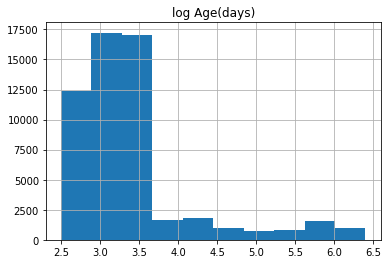

In [16]:
# harsh simplifications

# employees_in_account_plan: 1-4, 5+ category
x3 = x2.copy()
x3.loc[x2.employees_in_account_plan>5,'employees_in_account_plan'] = 5
display(x3.employees_in_account_plan.value_counts())

# discount_percentage 55 and 100 values re-binned
x4 = x3.copy()
x4.loc[x3.discount_percentage==100,'discount_percentage'] = 60
x4.loc[x3.discount_percentage==55,'discount_percentage'] = 50
display(x4.discount_percentage.value_counts())

# marketing_source missing to be used as hierarchical mean
x5 = x4.copy()
x5.loc[x4.marketing_source.isnull(),'marketing_source'] = 'Unspecified'
display(x5.marketing_source.value_counts())

# discount_code with less than 100 appearances is moved to na
x6 = x5.copy()
drop_set = x5.discount_code.value_counts()
drop_set = drop_set.index[drop_set<1000]
x6.loc[x5.discount_code.apply(lambda x: x in drop_set),'discount_code'] = np.NaN
x6.loc[x6.discount_code.isnull(), 'discount_code'] = 'Unspecified'
display(x6.discount_code.value_counts())
print('LEAVING '+str(x5.discount_code.apply(lambda x: x in drop_set).sum())+
      ' ROWS ('+str(np.round(len(drop_set)/x5.shape[0]*100,3))+
      '% OF ROWS) COMPRISING '+str(len(drop_set))+ ' CODES UNEVALUATED')

display(pd.pivot_table(x6[['account_created_at','discount_percentage','discount_code']],
                       index='discount_percentage',
                       columns='discount_code',
                       aggfunc=len))


# missing supporter dropped -- trashing 96 rows
x7 = x6[x6.supporter.notnull()]
display(x7.supporter.value_counts())

# sizing previously restricted
display(x7.sizing.value_counts())

# account ages added
x8 = ((datetime.datetime(2014,12,10)-x7['account_created_at'])/np.timedelta64(1,'D')).apply(np.log).to_frame('logAge(days)')
x8 = x8.join(x7)
x8['logAge(days)'].hist()
_=plt.title('log Age(days)')



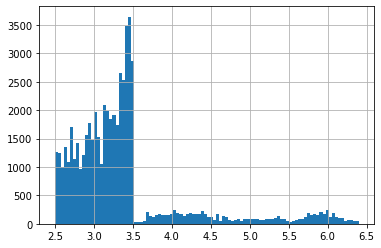

old_account        9528
mature_account    23153
dtype: int64

22597


,old_account,mature_account
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [17]:
# While sacrificing association extrapolation,
# arbitrary binning of accout duration 
# enables categorical variable treatment 
x8['logAge(days)'].hist(bins=100)
plt.show()

X_duration = (x8['logAge(days)']>3.5).to_frame('old_account')
X_duration = X_duration.join(((x8['logAge(days)']>3.14) & (x8['logAge(days)']<3.5)).to_frame('mature_account')).astype(int)
display(X_duration.sum(axis=0))
print(X_duration.shape[0]-X_duration.sum(axis=0).sum())
display(X_duration.head())

In [18]:
# producing indicator variables -- referent groups set at most prevalent level

# referent 'size-01'
X_sizing = pd.get_dummies(x8.sizing)[['size-05','size-06','size-07','size-08']]
display(X_sizing.head())

# referent 'n_2'
X_employees_in_account_plan = pd.get_dummies(x8.employees_in_account_plan, prefix='n')[['n_2','n_3','n_4','n_5']]
display(X_employees_in_account_plan.head())

# referent 'weak'
X_supporter = pd.get_dummies(x8.supporter)[['medium','strong']]
display(X_supporter.head())

# referent 'Unspecified'
X_discount_code = pd.get_dummies(x8.discount_code)[['code-04','code-164','code-53']]
display(X_discount_code.head())

# referent 'Unspecified'
X_marketing_source = pd.get_dummies(x8.marketing_source)[['source-01','source-02','source-03','source-04','source-05','source-06']]
display(X_marketing_source.head())

# referent 'dp_50'
X_discount_percentage = pd.get_dummies(x8.discount_percentage, prefix='dp')[['dp_20','dp_60']]
display(X_discount_percentage.head())

,size-05,size-06,size-07,size-08
0,0,0,0,1
1,0,1,0,0
2,1,0,0,0
3,0,0,0,0
4,0,0,0,0


,n_2,n_3,n_4,n_5
0,0,0,0,0
1,0,0,0,0
2,1,0,0,0
3,0,0,0,0
4,1,0,0,0


,medium,strong
0,1,0
1,1,0
2,0,0
3,0,0
4,0,0


,code-04,code-164,code-53
0,0,0,0
1,0,0,0
2,1,0,0
3,1,0,0
4,0,0,0


,source-01,source-02,source-03,source-04,source-05,source-06
0,0,0,0,0,0,1
1,0,0,0,0,0,0
2,0,0,0,1,0,0
3,0,0,0,0,0,1
4,0,0,0,1,0,0


,dp_20,dp_60
0,0,0
1,1,0
2,0,0
3,0,0
4,0,0


In [19]:
# forcing additive increases based on employee count

X_employees_in_account_plan = X_employees_in_account_plan[['n_5','n_4','n_3','n_2']].\
                              cumsum(axis=1)[['n_2','n_3','n_4','n_5']]
    
X_employees_in_account_plan.head(30)

,n_2,n_3,n_4,n_5
0,0,0,0,0
1,0,0,0,0
2,1,0,0,0
3,0,0,0,0
4,1,0,0,0
5,1,1,0,0
7,1,0,0,0
8,0,0,0,0
9,1,0,0,0
10,0,0,0,0


In [20]:
t = (x7.treatment_group=='Treatment').astype(int).to_frame('t')

X = t.join(X_sizing).\
      join(X_employees_in_account_plan).\
      join(X_supporter).\
      join(X_discount_code).\
      join(X_marketing_source).\
      join(X_discount_percentage).\
      join(X_duration)

X.head()

,t,size-05,size-06,size-07,size-08,n_2,n_3,n_4,n_5,medium,strong,code-04,code-164,code-53,source-01,source-02,source-03,source-04,source-05,source-06,dp_20,dp_60,old_account,mature_account
0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


# 2. Experimental Design Evaluated

In [21]:
# multicollinearity is quite unconcerning for this experiement -- all VIFs except logDaysAge are low
# high multicollinearity involving the treatment could lead to reduced precision in treatment effects

for c in range(X.shape[1]):
    print('VIF for feature '+X.columns[c]+' is: '+str(np.round(variance_inflation_factor(X.values, c),2)))
    #print('VIF for feature '+X.columns[c]+' is: '+str(np.round(variance_inflation_factor(X.values[kp,:], c),2)))
    

VIF for feature t is: 1.76
VIF for feature size-05 is: 1.18
VIF for feature size-06 is: 1.31
VIF for feature size-07 is: 1.02
VIF for feature size-08 is: 1.89
VIF for feature n_2 is: 2.13
VIF for feature n_3 is: 1.78
VIF for feature n_4 is: 1.98
VIF for feature n_5 is: 1.54
VIF for feature medium is: 1.55
VIF for feature strong is: 1.01
VIF for feature code-04 is: 1.44
VIF for feature code-164 is: 2.11
VIF for feature code-53 is: 1.34
VIF for feature source-01 is: 1.09
VIF for feature source-02 is: 1.13
VIF for feature source-03 is: 1.46
VIF for feature source-04 is: 2.05
VIF for feature source-05 is: 1.24
VIF for feature source-06 is: 2.15
VIF for feature dp_20 is: 1.44
VIF for feature dp_60 is: 1.37
VIF for feature old_account is: 1.75
VIF for feature mature_account is: 2.01


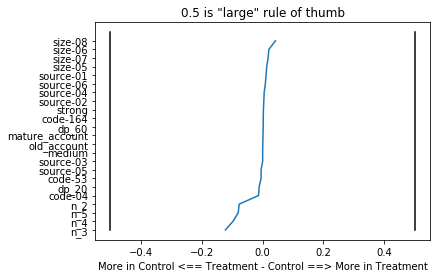


Summary Statistics

                     Controls (N_c=28631)       Treated (N_t=26647)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.054        0.225        0.051        0.221       -0.002

                     Controls (N_c=28631)       Treated (N_t=26647)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.089        0.285        0.093        0.291        0.014
             X1        0.125        0.331        0.132        0.339        0.021
             X2        0.010        0.098        0.012        0.107        0.018
             X3        0.307        0.461        0.327        0.469        0.042
             X4        0.385        0.487        0.348        0.476       -0.077
      

In [22]:
# another way to examine effect confounding is through covariate balance
# (which would induce multicollinearity with the treatment)
# we here see covariate balance is quite good

# had balance not been good we could trim high propensity score rows:
# causal.est_propensity_s()
# causal.trim_s()
# print(causal.propensity)
# plt.hist(causal.propensity['fitted'])
# kp = causal.propensity['fitted']>.45
# plt.hist(causal.propensity['fitted'][kp])

Y = (x7.tier1_converted_at>datetime.datetime(2014,11,6)).astype(int).values[:,np.newaxis]
causal = CausalModel(Y, X.values[:,:1], X.values[:,1:])

ndiff = causal.summary_stats['ndiff']#np.abs()
rdr = np.argsort(ndiff)#range(len(ndiff))#
plt.plot(ndiff[rdr], range(len(ndiff)))
plt.plot([-.5]*2,[0,len(rdr)],'k')
plt.plot([.5]*2,[0,len(rdr)],'k')
plt.title('0.5 is "large" rule of thumb' )
plt.yticks(range(len(ndiff)), X.columns[1:][rdr])
plt.xlabel('More in Control <== Treatment - Control ==> More in Treatment')
plt.show()

print(causal.summary_stats)


# 3. EDA Modeling

In [23]:
# Treatment does not appear to be universally positive, as expected

glm_binom = sm.GLM(Y, sm.add_constant(X), family=sm.families.Binomial())
glm_binom_results = glm_binom.fit()
display(glm_binom_results.summary().tables[0])
df = pd.read_html(glm_binom_results.summary().tables[1].as_html(), 
                  header=0, index_col=0)[0]
df = df.assign(f = -np.abs(df['z'])).sort_values('f').drop('f', axis=1)
df


Dep. Variable:,y,No. Observations:,55278
Model:,GLM,Df Residuals:,55253
Model Family:,Binomial,Df Model:,24
Link Function:,logit,Scale:,1.0
Method:,IRLS,Log-Likelihood:,-10248.
Date:,"Thu, 05 Sep 2019",Deviance:,20496.
Time:,07:08:22,Pearson chi2:,5.58e+04
No. Iterations:,8,,


,coef,std err,z,P>|z|,[0.025,0.975]
const,-3.8803,0.081,-47.640,0.000,-4.040,-3.721
size-08,1.8171,0.074,24.670,0.000,1.673,1.962
size-06,1.6604,0.080,20.823,0.000,1.504,1.817
size-05,1.4997,0.082,18.245,0.000,1.339,1.661
source-04,-0.7407,0.055,-13.535,0.000,-0.848,-0.633
size-07,1.8530,0.150,12.326,0.000,1.558,2.148
old_account,0.6683,0.057,11.706,0.000,0.556,0.780
medium,-0.3686,0.042,-8.795,0.000,-0.451,-0.286
dp_20,-0.3659,0.054,-6.717,0.000,-0.473,-0.259
source-05,-0.4827,0.081,-5.988,0.000,-0.641,-0.325


In [24]:
# Treatment does appear to be differentially effective in different contexts

t_intr = pd.DataFrame(X.values[:,1:]*X.values[:,:1],index=X.index, columns=['t*'+c for c in X.columns[1:]])
glm_binom = sm.GLM(Y, sm.add_constant(X.join(t_intr)), family=sm.families.Binomial())
glm_binom_results = glm_binom.fit()
display(glm_binom_results.summary().tables[0])
df = pd.read_html(glm_binom_results.summary().tables[1].as_html(), 
                  header=0, index_col=0)[0]
df = df.assign(f = -np.abs(df['z'])).sort_values('f').drop('f', axis=1)
df
    

Dep. Variable:,y,No. Observations:,55278
Model:,GLM,Df Residuals:,55230
Model Family:,Binomial,Df Model:,47
Link Function:,logit,Scale:,1.0
Method:,IRLS,Log-Likelihood:,-10228.
Date:,"Thu, 05 Sep 2019",Deviance:,20457.
Time:,07:08:25,Pearson chi2:,5.55e+04
No. Iterations:,9,,


,coef,std err,z,P>|z|,[0.025,0.975]
const,-4.1259,0.116,-35.512,0.000,-4.354,-3.898
size-08,2.1171,0.108,19.566,0.000,1.905,2.329
size-06,1.8716,0.116,16.096,0.000,1.644,2.100
size-05,1.7634,0.118,15.005,0.000,1.533,1.994
source-04,-0.8786,0.078,-11.255,0.000,-1.032,-0.726
size-07,2.1377,0.210,10.174,0.000,1.726,2.550
old_account,0.6322,0.079,7.994,0.000,0.477,0.787
medium,-0.3047,0.057,-5.301,0.000,-0.417,-0.192
source-06,-1.1586,0.267,-4.334,0.000,-1.683,-0.635
dp_20,-0.3170,0.074,-4.275,0.000,-0.462,-0.172


## Tenative observations *a priori* beliefs

- more employees does not indicate higher conversion; nor evidence increased lift opportunity
- larger account size indicates higher conversion; unfortunately, treatment undoes these gains
- brand support is not strongly influential; if anything it's detrimental to convesion and lift
- market source-01 has high conversion; lift on the low conversion on source-04 appears possible **<-- most interesting finding**
- discount code-04 and code-53 have good conversion; lift here seems unlikely
- percent discount seems positivel associated with conversion; poor evidence for lift opportunities though
- conversion is better for older accounts; lift does not seem strongly evidenced

# 4. Complexity Requirements

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


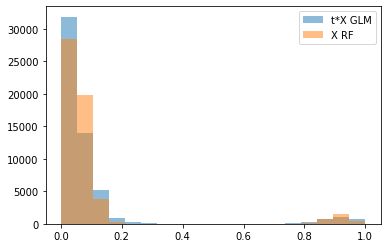

In [25]:
# It does not appear like we're leaving too much explanatory power on the table without 
# using higher-order interactions.

RF = RandomForestClassifier()
pargrid = {
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'min_samples_leaf': [5,25,100,200,500,1000],
    'n_estimators': [10,25,50,100,200]
}
search = GridSearchCV(RF, pargrid, cv=5, n_jobs=-1)#, verbose=2)
# we'll use original features
search.fit(X.values,glm_binom.endog)
print(search.best_estimator_)

plt.hist(np.abs(glm_binom_results.predict(glm_binom.exog)-glm_binom.endog), alpha=.5, bins=np.linspace(0,1,20), label='t*X GLM')
plt.hist(np.abs(search.best_estimator_.predict_proba(X.values)[:,1]-glm_binom.endog), alpha=.5, bins=np.linspace(0,1,20), label='X RF')
plt.legend()


Text(0.5, 0, 'Relative Importance')

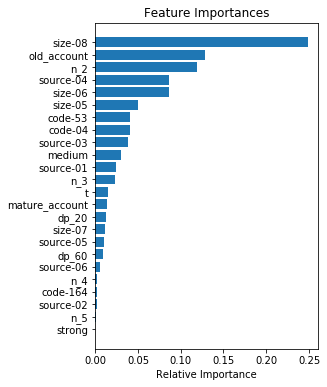

In [26]:
# glance at the main drivers in the RF

plt.figure(figsize=[4,6])
indices = np.argsort(search.best_estimator_.feature_importances_)
plt.title('Feature Importances')
plt.barh(range(len(indices)), search.best_estimator_.feature_importances_[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')


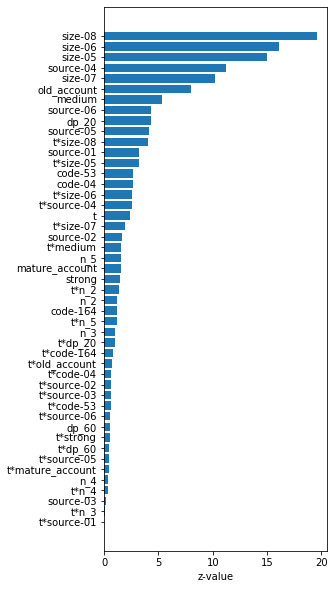

In [27]:
# and compared to the t*X glm it's quite comparable

plt.figure(figsize=[4,10])
rdr=range(df.shape[0]-1,0,-1)
plt.barh(rdr,np.abs(df.z[1:]))
plt.xlabel('z-value')
_=plt.yticks(rdr,df.index[1:])


# 5. Information Characterization

In [28]:
# create interactions
def interact(A,B):
    X = A.iloc[:,:0]
    for a in A:
        for b in B:
            X = X.join(pd.DataFrame({a+'*'+b: A[a]*B[b]},index=A.index))
    return X

In [29]:

Xs = {}
Xs['X_sizing'] = X_sizing
Xs['X_duration'] = X_duration
Xs['X_marketing_source'] = X_marketing_source
Xs['X_discount_code'] = X_discount_code
Xs['X_supporter'] = X_supporter
Xs['X_discount_percentage'] = X_discount_percentage
Xs['X_employees_in_account_plan'] = X_employees_in_account_plan
Xs_mains = list(Xs.keys())

# main effects
mains = X_sizing.iloc[:,:0]                    
for i in Xs_mains:
    mains = mains.join(Xs[i])                

mains_q = mains.shape[1]
print(mains_q)


# first order interactions
pairs = mains.iloc[:,:0]
for i in Xs_mains:
    for j in Xs_mains:
        if i<j:
            Xs[i+'_'+j] = interact(Xs[i],Xs[j])
            pairs = pairs.join(Xs[i+'_'+j])

pairs_q = pairs.shape[1]
print(pairs_q)
            
            

# second order interactions
fulls = mains.iloc[:,:0]
for i in Xs_mains:
    for j in Xs_mains:
        for k in Xs_mains:
            if i<j and j<k:
                Xs[i+'_'+j+'_'+k] = interact(Xs[i+'_'+j],Xs[k])
                fulls = fulls.join(Xs[i+'_'+j+'_'+k])

fulls_q = fulls.shape[1]
print(fulls_q)


n=mains.shape[0]
print(n)



23
220
1136
55278


In [30]:
# bring in treatments

tXmains = interact(X[['t']],mains)
tXpairs = interact(X[['t']],pairs)
tXfulls = interact(X[['t']],fulls)

In [31]:
# collapse data set for faster comp

def aggregate(X,Y):
    clms = [i for i in X.columns if '*' not in i]
    Xnew = X.drop_duplicates()
    Xmap={v:k for k,v in enumerate((Xnew[clms].astype(str)+'_').sum(axis=1))}

    key = (X[clms].astype(str)+'_').sum(axis=1)
    key = key.map(Xmap).values
    N = pd.DataFrame(dict(Counter(key)),index=['N']).T
    Ynew = pd.DataFrame({'Y':Y}).groupby(key).sum()
    return Xnew.astype(int),Ynew.astype(int).values,N.astype(int).values

dat = mains.join(pairs).\
            join(fulls).\
            join(X[['t']]).\
            join(tXmains).\
            join(tXpairs).\
            join(tXfulls).astype(int)

            
XX,YY,NN = aggregate(dat, Y)

XX.shape,YY.shape,NN.shape

((3423, 2759), (3423, 1), (3423, 1))

In [58]:
basic_model = pm.Model()

with basic_model:

    intercept = pm.Normal('intercept', mu=-4, sd=1, shape=(1,1))
    
    p0_mains = pm.Beta('p0_mains', alpha=1, beta=1)
    ss_mains = pm.Bernoulli('ss_mains', p=p0_mains, shape=mains_q)
    sigma_mains = pm.HalfNormal('sigma_mains', 1)
    beta_mains = pm.Normal('beta_mains', sd=1, shape=mains_q)
    
    p0_pairs = pm.Beta('p0_pairs', alpha=1, beta=1)
    ss_pairs = pm.Bernoulli('ss_pairs', p=p0_pairs, shape=pairs_q)
    sigma_pairs = pm.HalfNormal('sigma_pairs', 1)
    beta_pairs = pm.Normal('beta_pairs', sd=1, shape=pairs_q)

    #p0_fulls = pm.Beta('p0_fulls', alpha=1, beta=1)
    #ss_fulls = pm.Bernoulli('ss_fulls', p=p0_fulls, shape=fulls_q)
    #beta_fulls = pm.Normal('beta_fulls', sd=1, shape=fulls_q)
    
    treatment = pm.Normal('treatment', mu=0, sd=1, shape=(1,1))

    #p0_tXmains = pm.Beta('p0_tXmains', alpha=1, beta=1)
    #ss_tXmains = pm.Bernoulli('ss_tXmains', p=p0_tXmains, shape=mains_q)
    sigma_tXmains = pm.HalfNormal('sigma_tXmains', 1)
    beta_tXmains = pm.Normal('beta_tXmains', sd=1, shape=mains_q)
    
    #p0_tXpairs = pm.Beta('p0_tXpairs', alpha=1, beta=1)
    #ss_tXpairs = pm.Bernoulli('ss_tXpairs', p=p0_tXpairs, shape=pairs_q)
    sigma_tXpairs = pm.HalfNormal('sigma_tXpairs', 1)
    beta_tXpairs = pm.Normal('beta_tXpairs', sd=1, shape=pairs_q)

    ##p0_tXfulls = pm.Beta('p0_tXfulls', alpha=1, beta=1)
    ##ss_tXfulls = pm.Bernoulli('ss_tXfulls', p=p0_tXfulls, shape=fulls_q)
    #sigma_tXfulls = pm.HalfNormal('sigma_tXfulls', 1)
    #beta_tXfulls = pm.Normal('beta_tXfulls', sd=1, shape=fulls_q)
    
    levels_1stOrder = pm.Deterministic('levels_1stOrder', ss_mains*beta_mains*sigma_mains)
    levels_2ndOrder = pm.Deterministic('levels_2ndOrder', ss_pairs*beta_pairs*sigma_pairs)
    levels_1stOrder_treatments = pm.Deterministic('levels_1stOrder_treatments', ss_mains*beta_tXmains*sigma_tXmains)
    levels_2ndOrder_treatments = pm.Deterministic('levels_2ndOrder_treatments', ss_pairs*beta_tXpairs*sigma_tXpairs)
    
    
    lm = pm.Deterministic('lm', intercept + pm.math.dot(XX[mains.columns], levels_1stOrder)\
                                          + pm.math.dot(XX[pairs.columns], levels_2ndOrder)\
           + XX[['t']].T.values*treatment + pm.math.dot(XX[tXmains.columns], levels_1stOrder_treatments)\
                                          + pm.math.dot(XX[tXpairs.columns], levels_2ndOrder_treatments))#\
                                          #+ pm.math.dot(XX[fulls.columns], ss_fulls*beta_fulls)\
                                          #+ pm.math.dot(XX[tXfulls.columns], ss_fulls*beta_tXfulls*sigma_tXfulls))
            
    pm.Binomial('data', p=pm.math.sigmoid(lm), n=NN.T, observed=YY.T)
    
    

In [79]:
tmp = pm.model_to_graphviz(basic_model)
tmp.body = [i.replace('~','\n~') for i in tmp.body]
tmp.render('hierarchy', view=True)


'hierarchy.pdf'

In [168]:

with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500)

#display(pm.summary(trace))


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [beta_tXpairs, sigma_tXpairs, beta_tXmains, sigma_tXmains, treatment, beta_pairs, sigma_pairs, p0_pairs, beta_mains, sigma_mains, p0_mains, intercept]
>BinaryGibbsMetropolis: [ss_mains, ss_pairs]
Sampling 2 chains, 9 divergences: 100%|██████████| 2000/2000 [35:41<00:00,  1.48s/draws] 
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


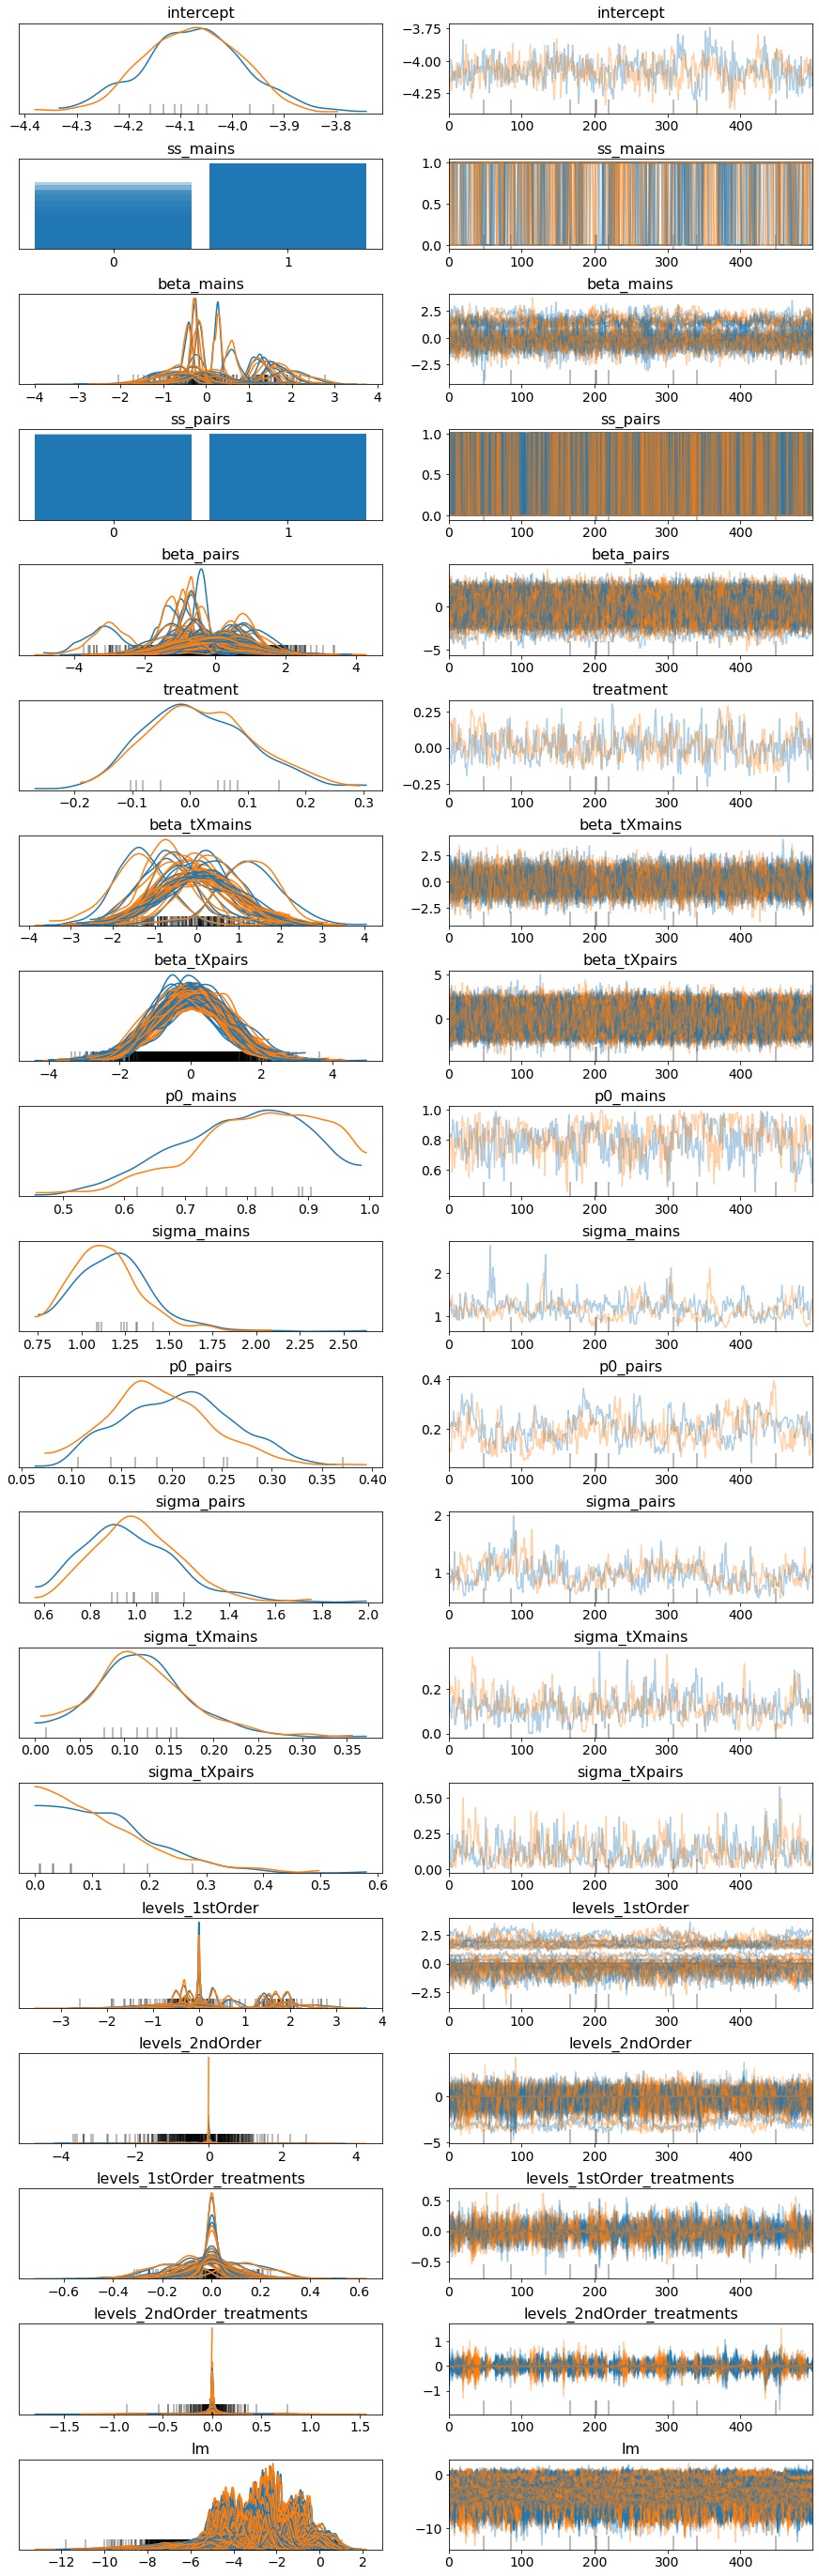

In [169]:
_=pm.traceplot(trace)

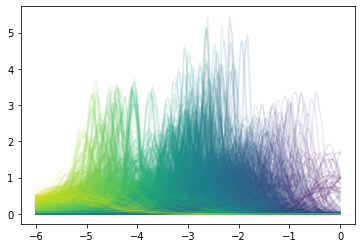

In [130]:
cmap = matplotlib.cm.get_cmap('viridis')

support = np.linspace(-6,0,1000)
for i in range(trace['lm'].shape[2]):
    
    kde = gaussian_kde(trace['lm'][:,0,i])
    _=plt.plot(support,kde.evaluate(support), c=cmap(int(256*(trace['lm'][:,0,i].mean()/-6))), alpha=.1)

plt.savefig('levels.png')


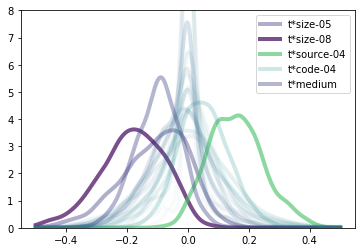

In [167]:

support = np.linspace(-.5,.5,1000)
for i in range(trace['levels_1stOrder_treatments'].shape[1]):
    
    kde = gaussian_kde(trace['levels_1stOrder_treatments'][:,i])
    placement = trace['levels_1stOrder_treatments'][:,i].mean()
    if np.abs(placement)<.05:
        _=plt.plot(support,kde.evaluate(support), 
                   alpha=np.abs(placement)*4,
                   c=cmap(int(2*256*(placement+.2))),
                   linewidth=4)
    else:
        _=plt.plot(support,kde.evaluate(support), 
                   alpha=np.abs(placement)*4,
                   c=cmap(int(2*256*(placement+.2))),
                   linewidth=4,label=tXmains.columns[i])
        
        
plt.ylim([0,8])
plt.legend()
plt.savefig('effects.png')

In [246]:
# example lift 

reference = (XX['source-04']==1)&(XX[['t']+mains.columns.tolist()].sum(axis=1)==1)
#target = (XX[['t','source-04','t*source-04']].sum(axis=1)==3)&(XX[['t']+mains.columns.tolist()+tXmains.columns.tolist()].sum(axis=1)==3)

def sigmoid(x):
    return (1+np.exp(-x))**-1

np.percentile(((sigmoid(trace['lm'][:,0,target])-sigmoid(trace['lm'][:,0,reference]))/sigmoid(trace['lm'][:,0,reference])).T[0],[15,85])


array([0.00337132, 0.37515916])

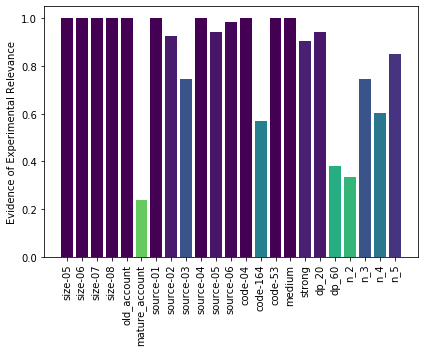

In [291]:
plt.figure(figsize=(6,5))

for i,rate in enumerate(trace['ss_mains'].mean(axis=0)):
    _=plt.bar(height=rate,x=i,color=cmap(int(256*(1-rate))))


plt.ylabel('Evidence of Experimental Relevance')
plt.xticks(range(len(mains.columns)),mains.columns, rotation=90)
plt.tight_layout()
plt.savefig('select1.png')

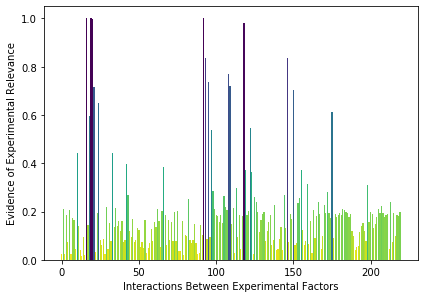

In [296]:
plt.figure(figsize=(6,4.25))

for i,rate in enumerate(trace['ss_pairs'].mean(axis=0)):
    _=plt.bar(height=rate,x=i,color=cmap(int(256*(1-rate))))

plt.xlabel('Interactions Between Experimental Factors')
plt.ylabel('Evidence of Experimental Relevance')
plt.tight_layout()
plt.savefig('select2.png')

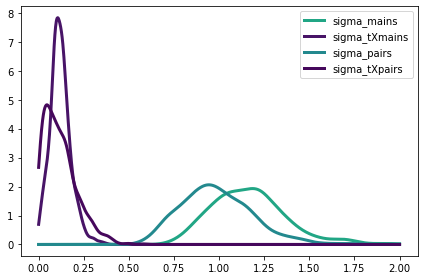

In [287]:
support = np.linspace(0,2,1000)
kde = gaussian_kde(trace['sigma_mains'])
plt.plot(support,kde.evaluate(support),label='sigma_mains',
         linewidth=3,
         c=cmap(int(256*kde.evaluate(support).argmax()/1000)))
kde = gaussian_kde(trace['sigma_tXmains'])
plt.plot(support,kde.evaluate(support),label='sigma_tXmains',
         linewidth=3,
         c=cmap(int(256*kde.evaluate(support).argmax()/1000)))
kde = gaussian_kde(trace['sigma_pairs'])
plt.plot(support,kde.evaluate(support),label='sigma_pairs',
         linewidth=3,
         c=cmap(int(256*kde.evaluate(support).argmax()/1000)))
kde = gaussian_kde(trace['sigma_tXpairs'])
plt.plot(support,kde.evaluate(support),label='sigma_tXpairs',
         linewidth=3,
         c=cmap(int(256*kde.evaluate(support).argmax()/1000)))
_=plt.legend()

plt.tight_layout()
plt.savefig('shrinkage')

592

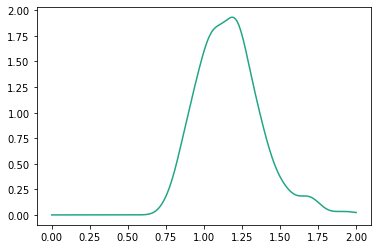

In [267]:
kde = gaussian_kde(trace['sigma_mains'])
plt.plot(support,kde.evaluate(support),label='sigma_mains',c=cmap(int(256*kde.evaluate(support).argmax()/1000)))
kde.evaluate(support).argmax()

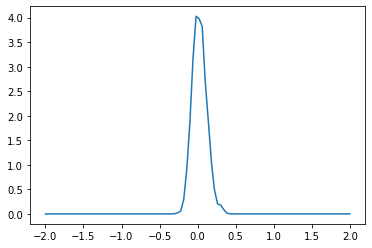

In [131]:

kde = gaussian_kde(trace['treatment'][:,0,0])
support = np.linspace(-2,2,100)
_=plt.plot(support,kde.evaluate(support))


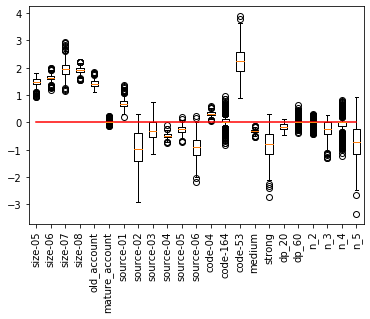

In [132]:

plt.boxplot(trace['ss_mains']*trace['beta_mains']*trace['sigma_mains'][:,np.newaxis])
plt.plot(range(1,trace['ss_mains'].shape[1]+1),[0]*trace['ss_mains'].shape[1],'r')
_=plt.xticks(range(1,trace['ss_mains'].shape[1]+1), mains.columns, rotation=90)

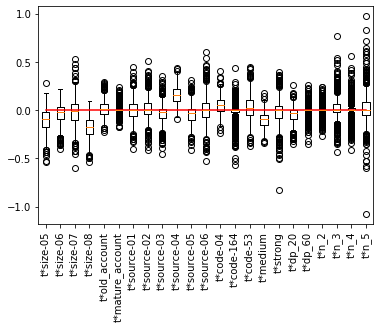

In [136]:

plt.boxplot(trace['ss_mains']*trace['beta_tXmains']*trace['sigma_tXmains'][:,np.newaxis])
plt.plot(range(1,trace['ss_mains'].shape[1]+1),[0]*trace['ss_mains'].shape[1],'r')
_=plt.xticks(range(1,trace['ss_mains'].shape[1]+1), tXmains.columns, rotation=90)

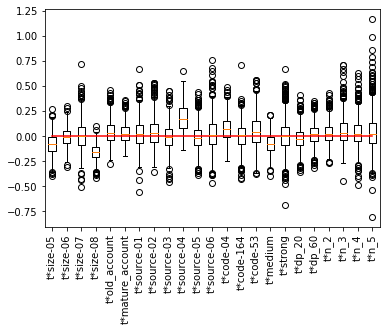

In [137]:

plt.boxplot(trace['ss_mains']*trace['beta_tXmains']*trace['sigma_tXmains'][:,np.newaxis]+trace['treatment'][:,0,:])
plt.plot(range(1,trace['ss_mains'].shape[1]+1),[0]*trace['ss_mains'].shape[1],'r')
_=plt.xticks(range(1,trace['ss_mains'].shape[1]+1), tXmains.columns, rotation=90)

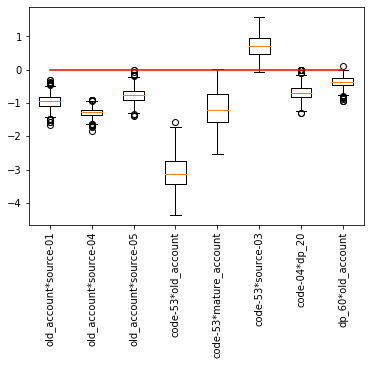

In [138]:
kp = (trace['ss_pairs'].mean(axis=0)>.75)

plt.boxplot((trace['ss_pairs']*trace['beta_pairs']*trace['sigma_pairs'][:,np.newaxis])[:,kp])
plt.plot(range(1,kp.sum()+1),[0]*kp.sum(),'r')
_=plt.xticks(range(1,kp.sum()+1), pairs.columns[kp], rotation=90)

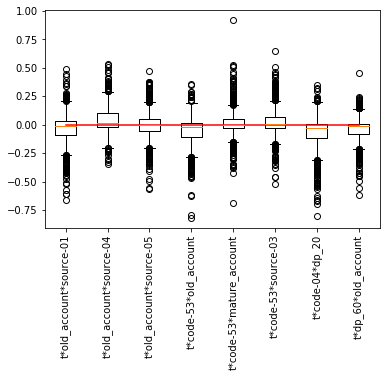

In [139]:
kp = (trace['ss_pairs'].mean(axis=0)>.75)

plt.boxplot((trace['ss_pairs']*trace['beta_tXpairs']*trace['sigma_tXpairs'][:,np.newaxis])[:,kp])
plt.plot(range(1,kp.sum()+1),[0]*kp.sum(),'r')
_=plt.xticks(range(1,kp.sum()+1), tXpairs.columns[kp], rotation=90)

In [259]:
plt.hist(trace['ss_tXpairs'].mean(axis=0))

KeyError: 'Unknown variable ss_tXpairs'

percent increase or decrease in each metric for users who received a new campaign versus a control group


these will be spike and slab and additive
they can potentially vary by Categorical below
And then interactive Category pairs
And then full interactive Category pairs

# Categorical
- size (important, 4 levels)
- account ages (important, 2 levels -- only ostensibly ordinal)
- discount (important, 2 levels -- only ostensibly ordinal)
- brand (2 levels -- probably just single jump at "Medium" -- only ostensibly ordinal)
- source (important, 6 levels)
- code (reduced to only 3 levels)
- employees (4 levels -- treated additively -- probably just single jump at "2")

4*2*6*3*4*2*2= -- 4*576 we can do all interactions
we can define shrinkage on the hierarchy to pull back out if information is weak


In [36]:
#ppc = pm.sample_ppc(trace, model=basic_model, samples=500)